<a href="https://colab.research.google.com/github/jahelsantiago/MINST-GANs/blob/main/Linear_MinstGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAHEL SANTIAGO LEON
jleonro@unal.edu.co

In [ ]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


#### MNIST Dataset
The training images that the discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:


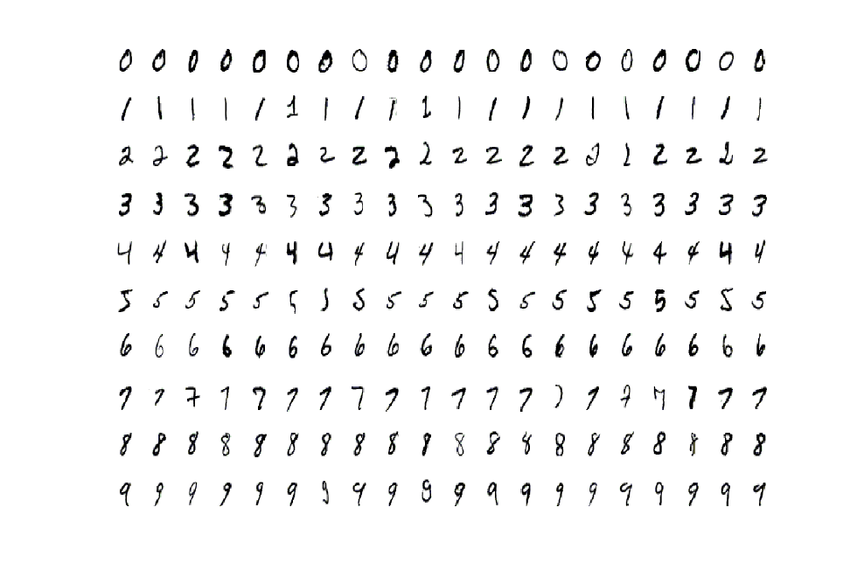

The basic idea beyond GANs is based on the creation of two models, a discriminator and a generator.
- **Generator:** is the model which has to generate the images from noise, it is composed by several blocks of a combination of linear,batch,relu each one.
- **Discriminator:** this model has to predict if a given image is real or fake.

## Generator block:
This is the basic brick which the generator is composed by.

In [ ]:
import torch
from torch import nn

def get_generator_block(input_dim,output_dim):
  """Returns a generator block
  Parameters:
  - input_dim (int): dimension of the input vectora
  - output_dim (int): dimension of the outpute vectora
  Retruns
  - tensor      
  """
  return nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.ReLU(inplace=True),
  )

## Generator model
This model recives a noise vector wich is the seed to create the new images and returns an new image.

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
    """
    z_dim (int): the dimension of the noise vector.
    im_dim (int): the dimension of the images, fitted for the dataset used. (MNIST images are 28 x 28 = 784 so that is your default)
    hidden_dim (int): the inner dimension.
    """
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim),
        get_generator_block(hidden_dim, hidden_dim * 2),
        get_generator_block(hidden_dim * 2, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 8),
        nn.Linear( hidden_dim * 8, im_dim),
        nn.Sigmoid()
    )
  def forward(self, noise):
    '''
    Function for completing a forward pass of the generator: Given a noise tensor, 
    returns generated images.
    Parameters:
        noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    return self.gen(noise)  

## Generate noise

This function allaw us to create noise image to feed our generator

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
  '''
  Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
  creates a tensor of that shape filled with random numbers from the normal distribution.
  Parameters:
    n_samples: the number of samples to generate, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
  '''
  return torch.randn(n_samples,z_dim,device=device)
  
  

## Discriminator block

In [ ]:
def get_discriminator_block(input_dim,output_dim):
  """
  Discriminator Block
  Function for returning a neural network of the discriminator given input and output dimensions.
  Parameters:
  - input_dim (int): the dimension of the input vector
  - output_dim (int: the dimension of the output vector
  Returns:
      a discriminator neural network layer, with a linear transformation 
        followed by an nn.LeakyReLU activation with negative slope of 0.2 
  """
  return nn.Sequential(
      nn.Linear(input_dim,output_dim),
      nn.LeakyReLU(negative_slope=0.2)
  )

## Discriminator model

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)            
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

## Losses

### Discriminator loss
These are the steps to create the generator loss
1.  Create noise vectors 
2.  Generate a batch (num_images) of fake images. It is important to detach the generator gradients.
4.  Get the discriminator's prediction of the fake image.
3.  Calculate the loss of the discriminator. 
  - Get the  discriminator's prediction of the fake image and calculate the loss. 
  -  Get the discriminator's prediction of the real image and calculate the loss. 
  - Calculate the discriminator's loss by averaging the real and fake loss
and set it to disc_loss. $loss = \frac{DiscLoss + GenLoss}{2}$



In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
  '''
  Return the loss of the discriminator given inputs.
  Parameters:
      gen: the generator model, which returns an image given z-dimensional noise
      disc: the discriminator model, which returns a single-dimensional prediction of real/fake
      criterion: the loss function, which should be used to compare 
            the discriminator's predictions to the ground truth reality of the images 
            (e.g. fake = 0, real = 1)
      real: a batch of real images
      num_images: the number of images the generator should produce, 
              which is also the length of the real images
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
  Returns:
      disc_loss: a torch scalar loss value for the current batch
  '''
  #generate noise
  noise = get_noise(num_images, z_dim, device)

  #generate fake images
  fake_img = gen(noise).detach()

  #pass the fake images to the discriminator
  disc_fake = disc(fake_img)

  #calculate the loss using as growntrue "0s" becuase all images are fake
  disc_loss_fake = criterion(disc_fake,torch.zeros_like(disc_fake))

  #pass the real images to the discriminator
  disc_real = disc(real)

  #calculate the using the as growntrue "1s" because all images are real
  disc_loss_real = criterion(disc_real, torch.ones_like(disc_real))

  #return the avarege between both
  return (disc_loss_fake+disc_loss_real)/2




### Generator loss
These are the steps you will need to complete:
1. Create noise vectors.
2. Generate a batch of fake images. 
3. Get the discriminator's prediction of the fake image.
4. Calculate the generator's loss. Remember the generator wants the discriminator to think that its fake images are real


In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
  '''
  Return the loss of the generator given inputs.
  Parameters:
    gen: the generator model, which returns an image given z-dimensional noise
    disc: the discriminator model, which returns a single-dimensional prediction of real/fake
    criterion: the loss function, which should be used to compare 
            the discriminator's predictions to the ground truth reality of the images 
            (e.g. fake = 0, real = 1)
    num_images: the number of images the generator should produce, 
            which is also the length of the real images
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
  Returns:
    gen_loss: a torch scalar loss value for the current batch
  '''
  #Generate the noise
  noise = get_noise(num_images,z_dim,device)
  
  #Predict generate the image
  gen_pred = gen(noise)

  #Discrimine the image into fake and real
  disc_pred = disc(gen_pred)

  #return the loss based on the criterion and using ones since the generator needs the discrimintor 
  return  criterion(disc_pred, torch.ones_like(disc_pred))


This is a helper function to show the generated images

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Training
Now, we set up our parameters
  *   criterion: the loss function
  *   n_epochs: the number of times we iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST # Training dataset
from torchvision import transforms

# Set parameters
criterion = nn.BCEWithLogitsLoss() 
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda:0'

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now we initialize our model

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Epoch 1, step 500: Generator loss: 1.456203075528144, discriminator loss: 0.42003774958848955


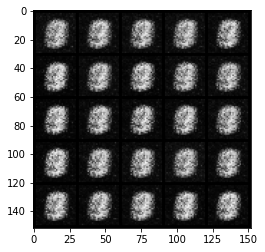

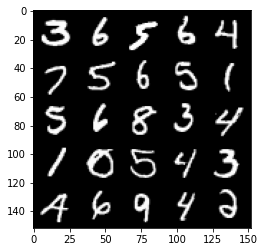

Epoch 2, step 1000: Generator loss: 1.7525593571662887, discriminator loss: 0.28495768710970887


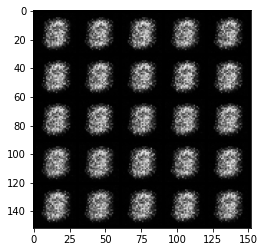

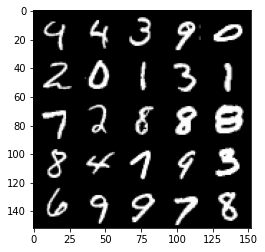

Epoch 3, step 1500: Generator loss: 2.0782603526115424, discriminator loss: 0.15988329282403


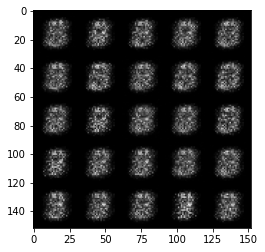

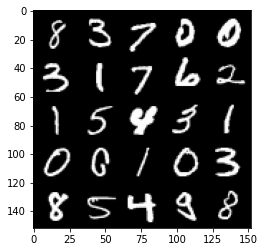

Epoch 4, step 2000: Generator loss: 1.760629118680956, discriminator loss: 0.2060843793451787


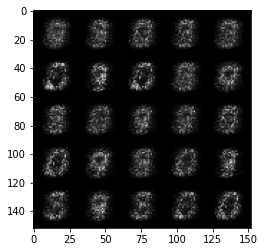

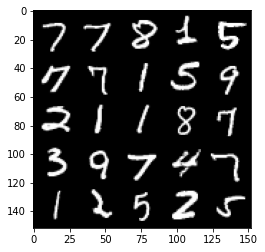

Epoch 5, step 2500: Generator loss: 1.6605537743568435, discriminator loss: 0.21527649965882295


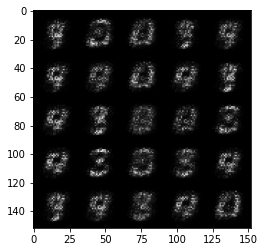

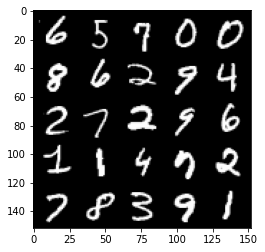

Epoch 6, step 3000: Generator loss: 1.958458154201506, discriminator loss: 0.15750477418303496


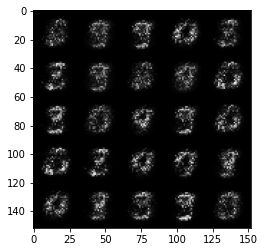

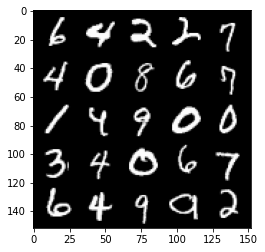

Epoch 7, step 3500: Generator loss: 2.375555358409881, discriminator loss: 0.1178580623269081


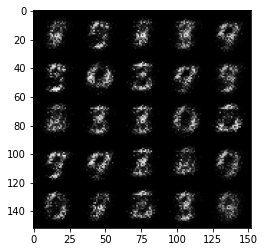

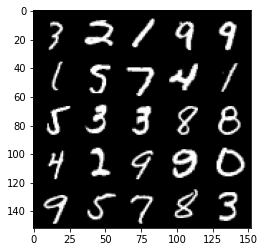

Epoch 8, step 4000: Generator loss: 2.754953407764434, discriminator loss: 0.10895459756255169


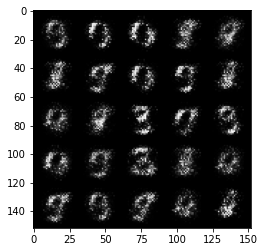

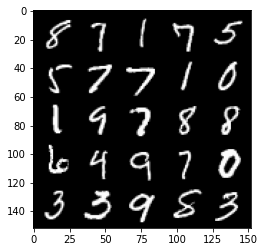

Epoch 9, step 4500: Generator loss: 2.8666967806816106, discriminator loss: 0.11826284715533246


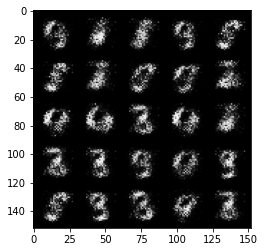

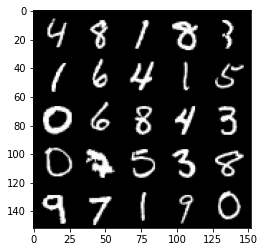

Epoch 10, step 5000: Generator loss: 3.177535839080812, discriminator loss: 0.09131445486098526


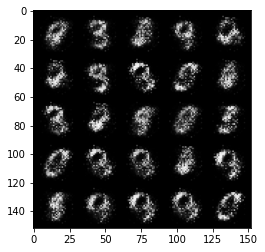

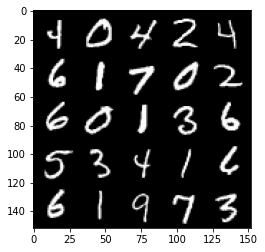

Epoch 11, step 5500: Generator loss: 3.5646148200035044, discriminator loss: 0.07542586804181331


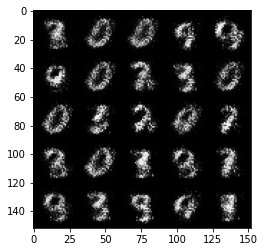

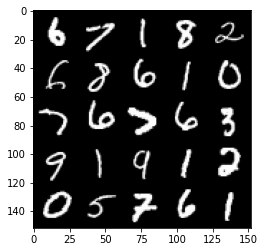

Epoch 12, step 6000: Generator loss: 3.6347717924118035, discriminator loss: 0.0771403587087989


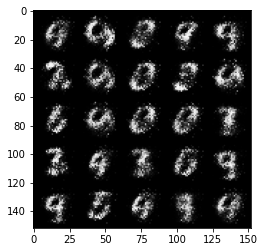

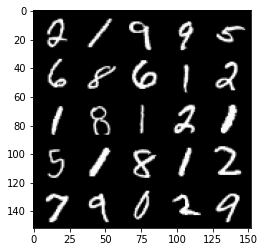

Epoch 13, step 6500: Generator loss: 3.9168014483451845, discriminator loss: 0.06722976042330263


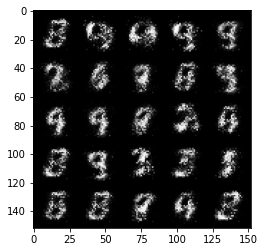

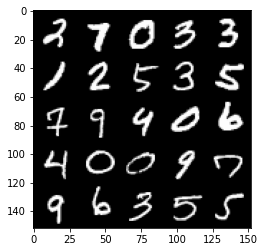

Epoch 14, step 7000: Generator loss: 4.021721217632295, discriminator loss: 0.06582234998047354


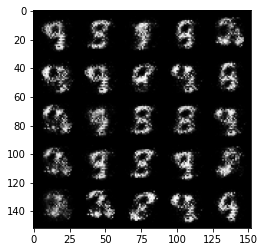

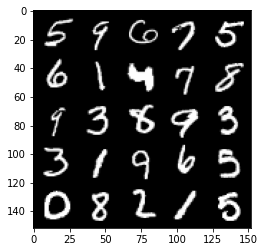

Epoch 15, step 7500: Generator loss: 3.861971783161163, discriminator loss: 0.059735979609191435


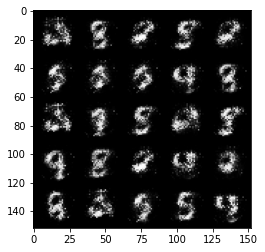

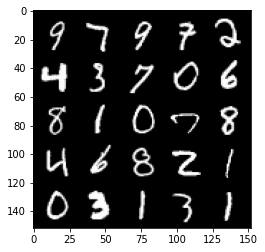

Epoch 17, step 8000: Generator loss: 3.9541275324821514, discriminator loss: 0.06042556344717741


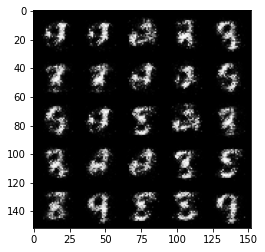

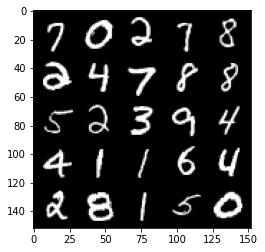

Epoch 18, step 8500: Generator loss: 3.8361929783821123, discriminator loss: 0.05996614782139653


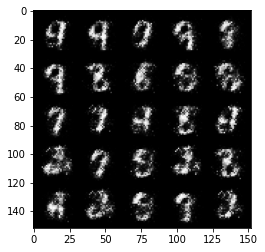

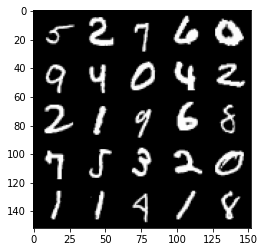

Epoch 19, step 9000: Generator loss: 3.865150370597838, discriminator loss: 0.07309966269135473


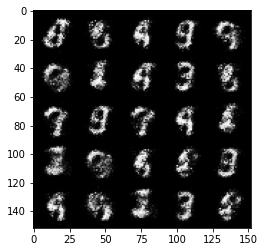

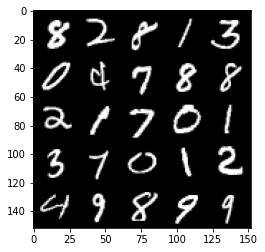

Epoch 20, step 9500: Generator loss: 3.85800522565842, discriminator loss: 0.06912771082669493


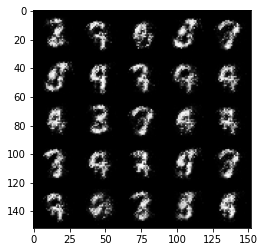

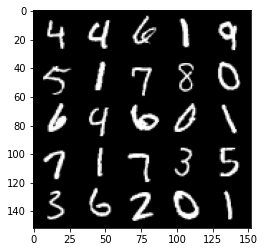

Epoch 21, step 10000: Generator loss: 4.110105104446413, discriminator loss: 0.062231318391859546


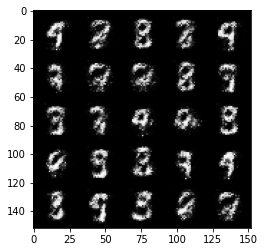

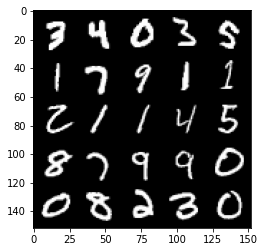

Epoch 22, step 10500: Generator loss: 4.181805372714995, discriminator loss: 0.06863638806343078


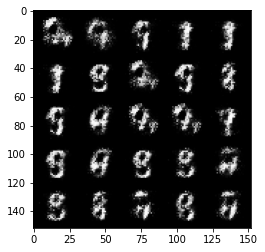

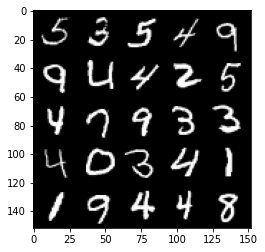

Epoch 23, step 11000: Generator loss: 4.069920598506927, discriminator loss: 0.06402375662326812


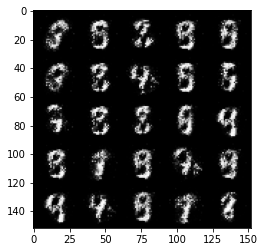

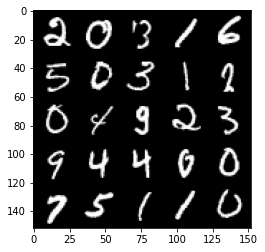

Epoch 24, step 11500: Generator loss: 4.011884568214417, discriminator loss: 0.06778310076892376


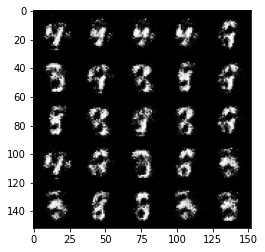

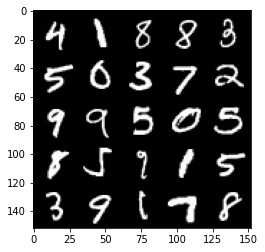

Epoch 25, step 12000: Generator loss: 4.280518105506899, discriminator loss: 0.060561385076493016


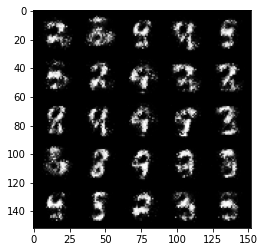

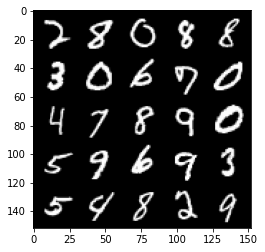

Epoch 26, step 12500: Generator loss: 4.154793429374695, discriminator loss: 0.0695424495562911


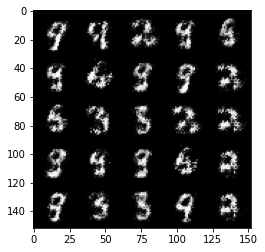

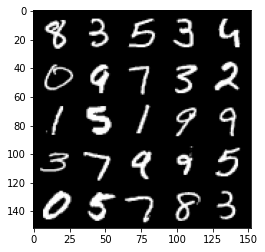

Epoch 27, step 13000: Generator loss: 3.953477689743044, discriminator loss: 0.06652550804242487


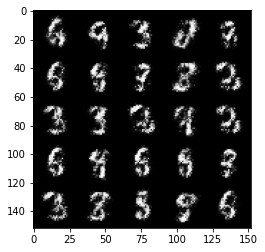

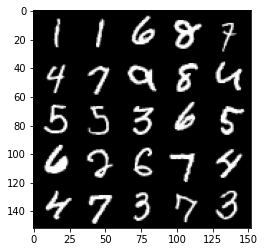

Epoch 28, step 13500: Generator loss: 3.9595901737213146, discriminator loss: 0.09158193707466125


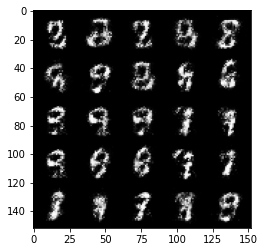

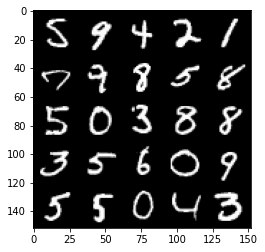

Epoch 29, step 14000: Generator loss: 3.846539487838748, discriminator loss: 0.09046790578961363


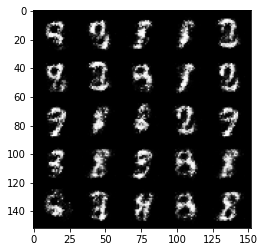

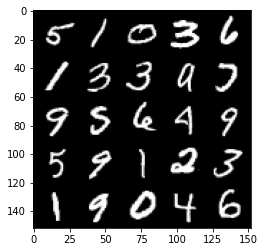

Epoch 30, step 14500: Generator loss: 3.748074902534484, discriminator loss: 0.10173309184610847


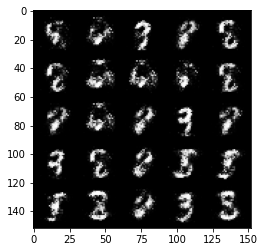

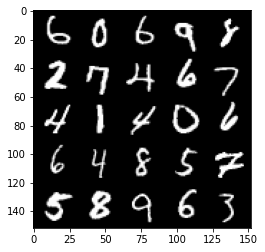

Epoch 31, step 15000: Generator loss: 3.6832384891510013, discriminator loss: 0.11184567651897674


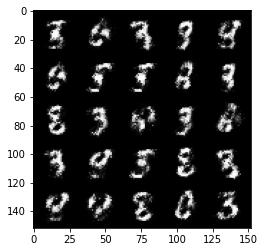

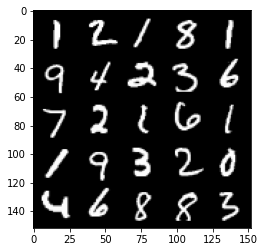

Epoch 33, step 15500: Generator loss: 3.7453581357002284, discriminator loss: 0.12361081681400538


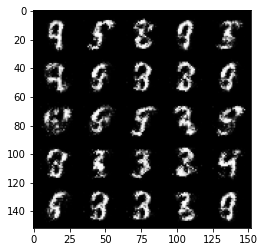

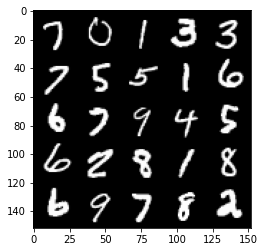

Epoch 34, step 16000: Generator loss: 3.65780082511902, discriminator loss: 0.13146436308324355


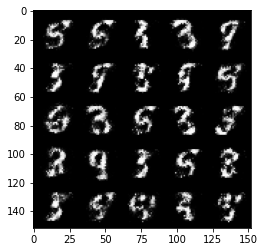

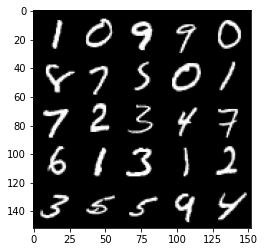

Epoch 35, step 16500: Generator loss: 3.5622633924484273, discriminator loss: 0.127646634310484


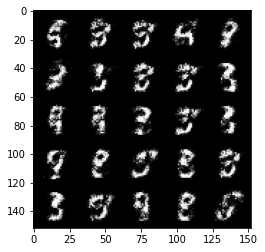

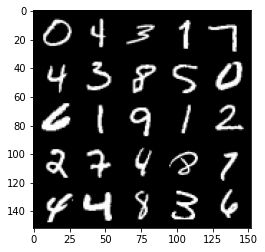

Epoch 36, step 17000: Generator loss: 3.5301482434272793, discriminator loss: 0.13485043498873717


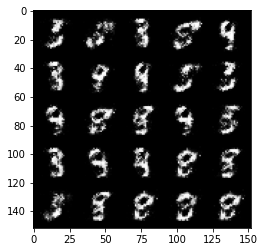

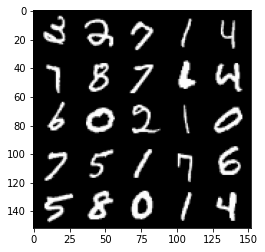

Epoch 37, step 17500: Generator loss: 3.559250060558322, discriminator loss: 0.12150839041918521


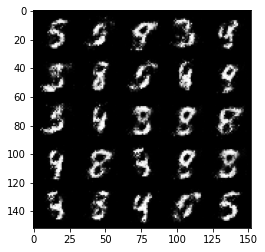

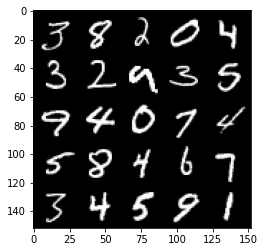

Epoch 38, step 18000: Generator loss: 3.5798428177833546, discriminator loss: 0.1311681848466396


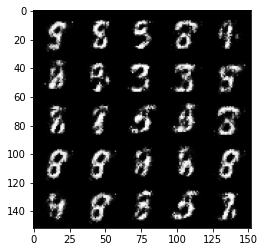

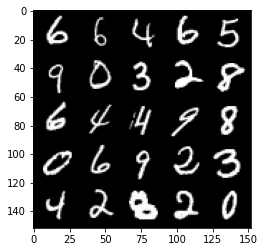

Epoch 39, step 18500: Generator loss: 3.3716672916412356, discriminator loss: 0.14551495307683943


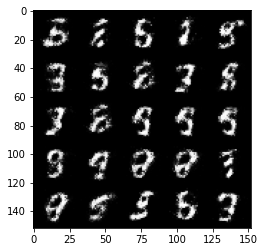

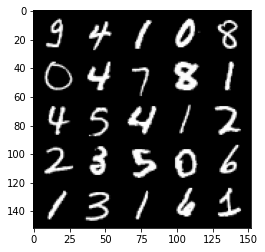

Epoch 40, step 19000: Generator loss: 3.4264089894294742, discriminator loss: 0.1449110269993544


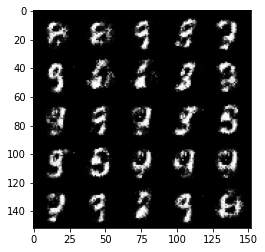

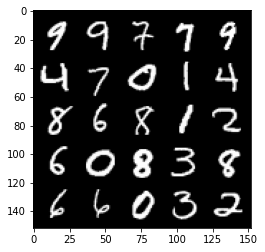

Epoch 41, step 19500: Generator loss: 3.251709069252016, discriminator loss: 0.14672237405180927


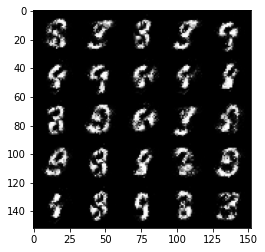

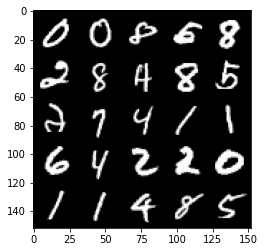

Epoch 42, step 20000: Generator loss: 3.18871972322464, discriminator loss: 0.1566711193472148


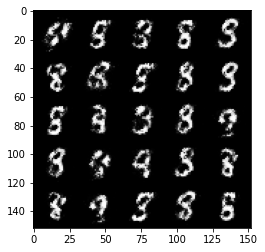

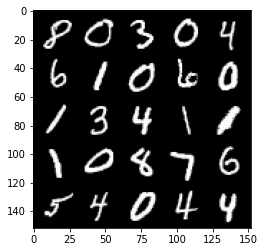

Epoch 43, step 20500: Generator loss: 3.1266092052459697, discriminator loss: 0.17760357509553443


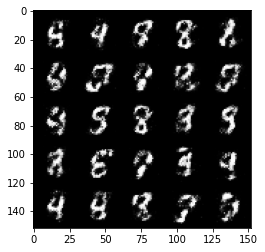

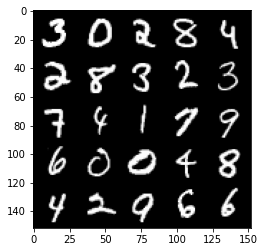

Epoch 44, step 21000: Generator loss: 3.0717016801834087, discriminator loss: 0.15738731762766836


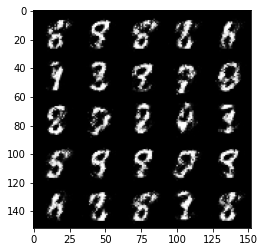

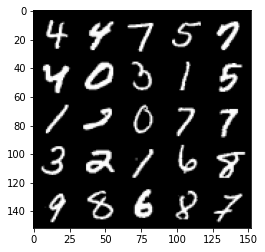

Epoch 45, step 21500: Generator loss: 3.0746187424659754, discriminator loss: 0.16869254156947133


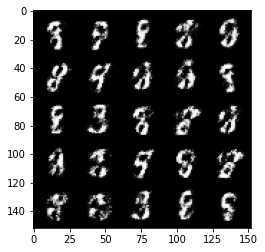

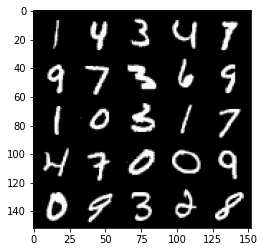

Epoch 46, step 22000: Generator loss: 3.1096935954093943, discriminator loss: 0.17028054276108756


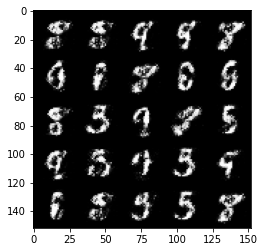

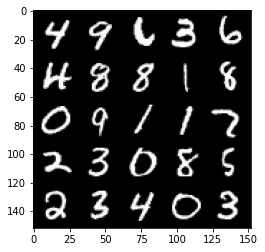

Epoch 47, step 22500: Generator loss: 3.0851438431739813, discriminator loss: 0.17169413584470747


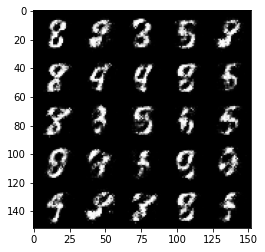

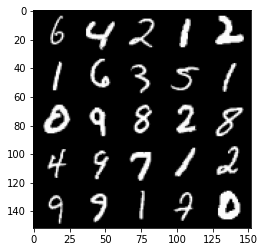

Epoch 49, step 23000: Generator loss: 2.97276426696777, discriminator loss: 0.18764048342406725


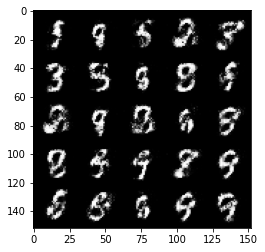

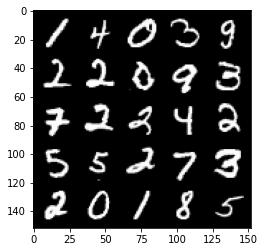

Epoch 50, step 23500: Generator loss: 2.9115749497413637, discriminator loss: 0.19770937699079533


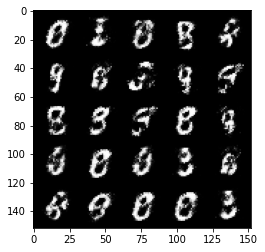

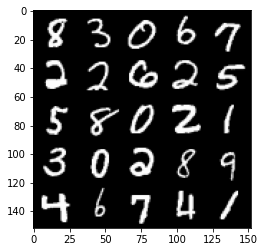

Epoch 51, step 24000: Generator loss: 2.854632014274599, discriminator loss: 0.1925633753687143


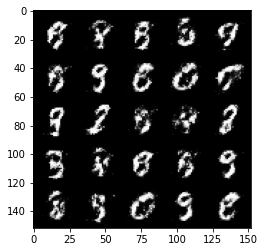

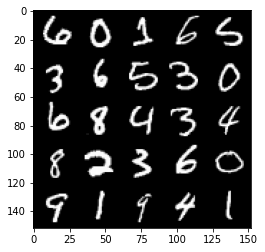

Epoch 52, step 24500: Generator loss: 3.004696836948393, discriminator loss: 0.18649722339212899


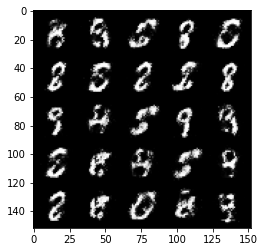

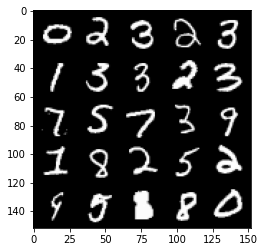

Epoch 53, step 25000: Generator loss: 2.9035319480895994, discriminator loss: 0.20947582069039372


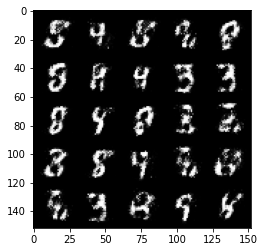

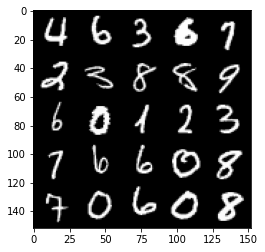

Epoch 54, step 25500: Generator loss: 2.9882950248718267, discriminator loss: 0.1904493127763274


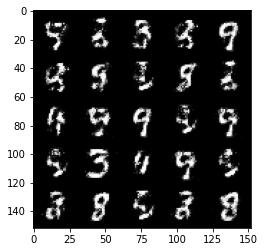

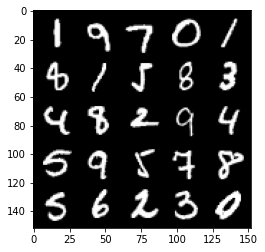

Epoch 55, step 26000: Generator loss: 2.8716818451881423, discriminator loss: 0.20006245307624332


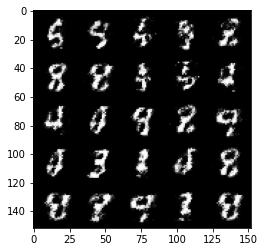

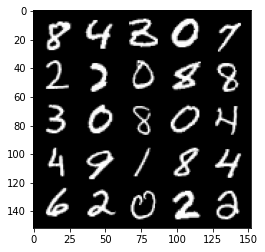

Epoch 56, step 26500: Generator loss: 3.003651837348939, discriminator loss: 0.19574722322821614


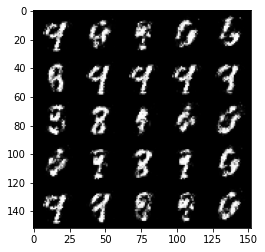

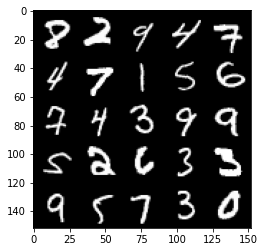

Epoch 57, step 27000: Generator loss: 2.7197599821090686, discriminator loss: 0.23466088956594447


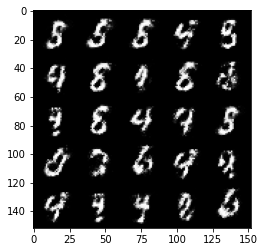

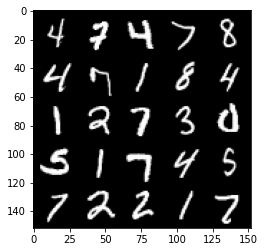

Epoch 58, step 27500: Generator loss: 2.662045045375824, discriminator loss: 0.24820479202270507


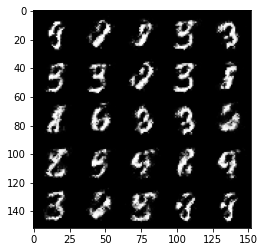

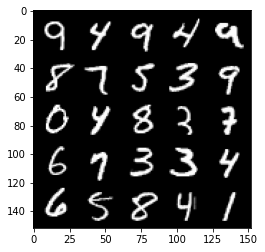

Epoch 59, step 28000: Generator loss: 2.6638993024826045, discriminator loss: 0.2321715496778488


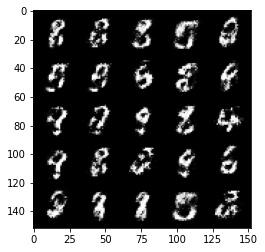

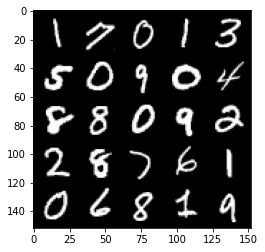

Epoch 60, step 28500: Generator loss: 2.6624117279052726, discriminator loss: 0.2321219495534895


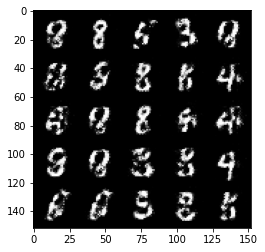

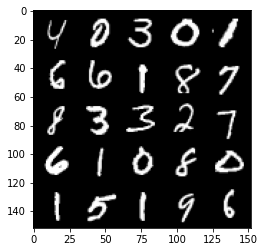

Epoch 61, step 29000: Generator loss: 2.725932671070098, discriminator loss: 0.2172765518426898


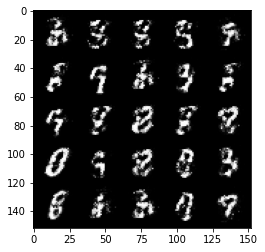

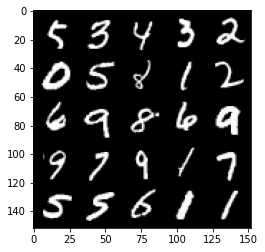

Epoch 62, step 29500: Generator loss: 2.5967462391853324, discriminator loss: 0.2564147507548331


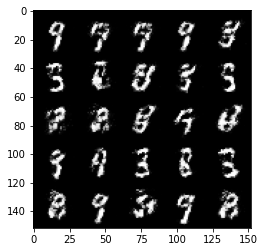

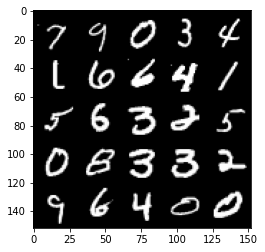

Epoch 63, step 30000: Generator loss: 2.638957886695864, discriminator loss: 0.24052455246448498


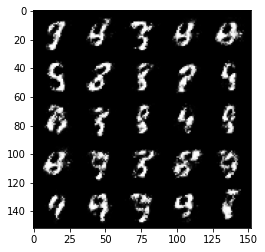

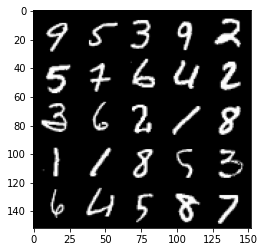

Epoch 65, step 30500: Generator loss: 2.5335210099220267, discriminator loss: 0.2590276840031148


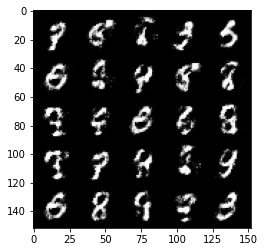

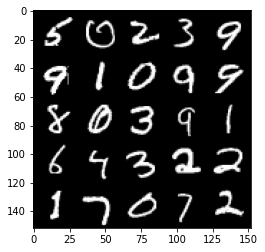

Epoch 66, step 31000: Generator loss: 2.5374299073219304, discriminator loss: 0.2658507327735422


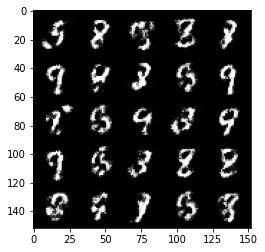

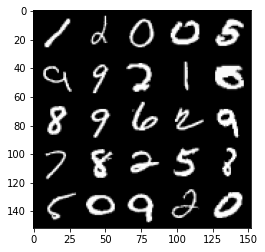

Epoch 67, step 31500: Generator loss: 2.5804272937774675, discriminator loss: 0.24020907104015363


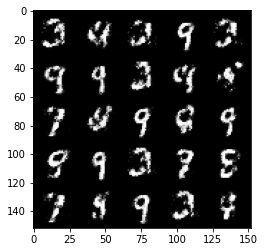

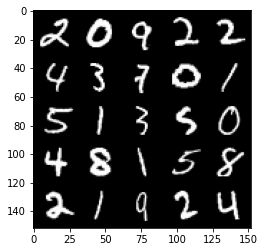

Epoch 68, step 32000: Generator loss: 2.6646973452568044, discriminator loss: 0.23634511038661013


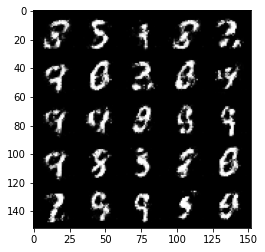

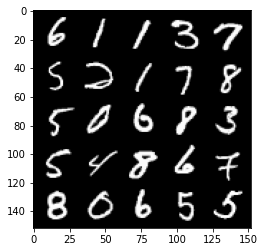

Epoch 69, step 32500: Generator loss: 2.614645966529847, discriminator loss: 0.24858433786034598


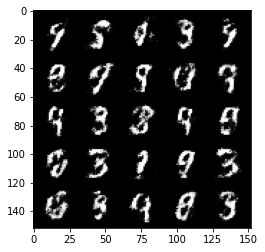

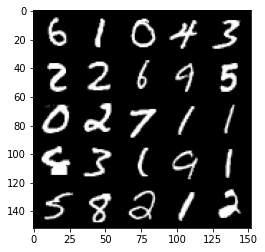

Epoch 70, step 33000: Generator loss: 2.6827641129493713, discriminator loss: 0.24900789019465439


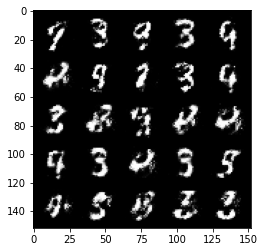

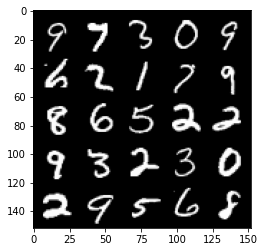

Epoch 71, step 33500: Generator loss: 2.609181900978087, discriminator loss: 0.2581843319535255


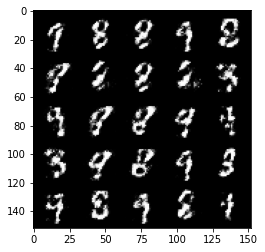

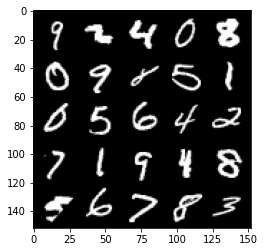

Epoch 72, step 34000: Generator loss: 2.6719122748374935, discriminator loss: 0.22600792270898828


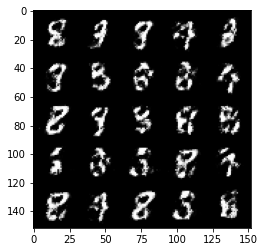

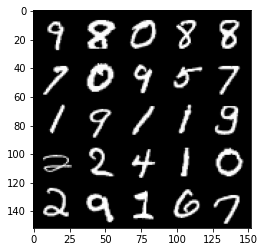

Epoch 73, step 34500: Generator loss: 2.5680036745071404, discriminator loss: 0.2503501454591753


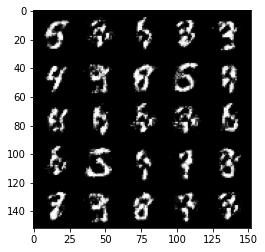

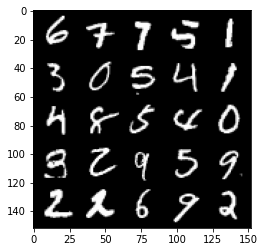

Epoch 74, step 35000: Generator loss: 2.461887909889222, discriminator loss: 0.2580011577010155


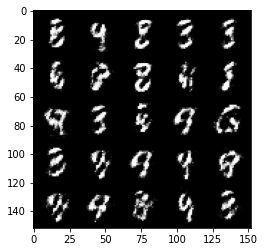

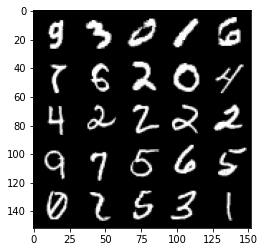

Epoch 75, step 35500: Generator loss: 2.404797724485396, discriminator loss: 0.27396535369753827


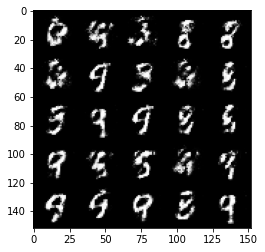

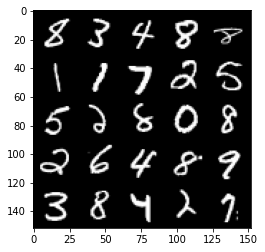

Epoch 76, step 36000: Generator loss: 2.3587602133750916, discriminator loss: 0.2767389002740382


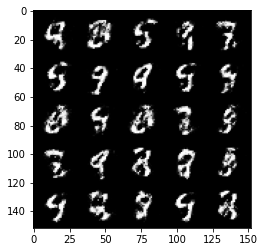

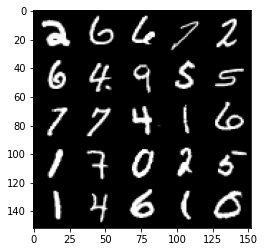

Epoch 77, step 36500: Generator loss: 2.3772143774032575, discriminator loss: 0.26526694265008


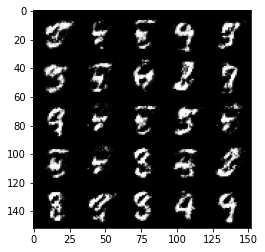

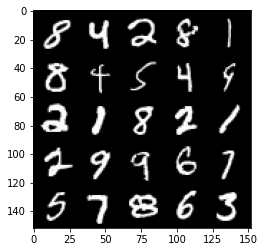

Epoch 78, step 37000: Generator loss: 2.4261867196559894, discriminator loss: 0.2539311825335024


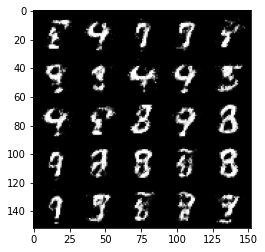

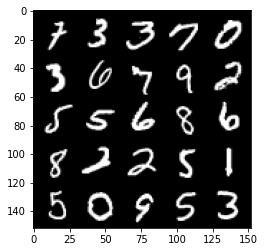

Epoch 79, step 37500: Generator loss: 2.2999433860778815, discriminator loss: 0.2831798228323458


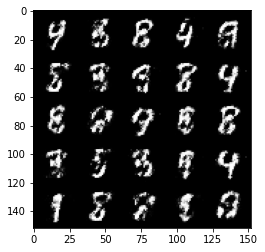

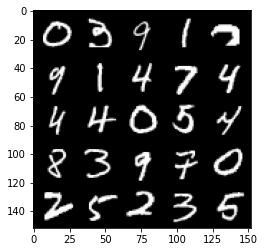

Epoch 81, step 38000: Generator loss: 2.3081546733379374, discriminator loss: 0.2981507275104522


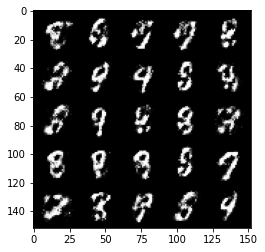

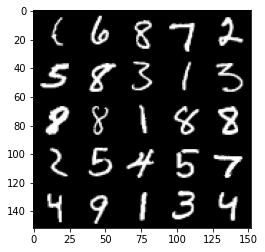

Epoch 82, step 38500: Generator loss: 2.2686703991889967, discriminator loss: 0.29365248918533315


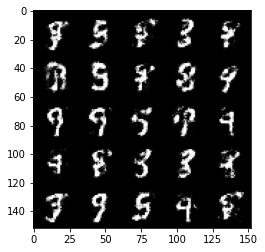

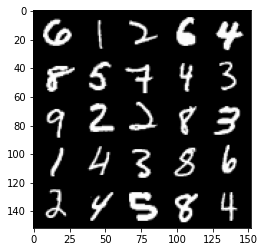

Epoch 83, step 39000: Generator loss: 2.259329516410827, discriminator loss: 0.29340172755718213


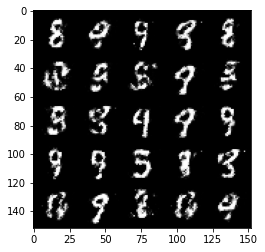

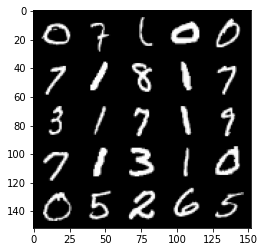

Epoch 84, step 39500: Generator loss: 2.2612320060729973, discriminator loss: 0.2914791309833524


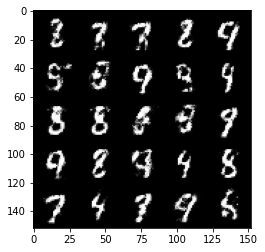

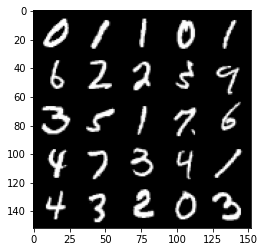

In [ ]:
from tqdm.auto import tqdm
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        #zero out grafientes
        gen_opt.zero_grad()

        # calculate generator loss
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)

        #update gradiente
        gen_loss.backward(retain_graph=True)

        #update optimizer
        gen_opt.step()                     

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
